# Dog Breeds 
### Kaggle competition
![doggo](https://kaggle2.blob.core.windows.net/competitions/kaggle/7327/logos/header.png)

### Imports

NOTE: this notebook requires fastai lib to be in same dir
- can be done by symlinking fastai folder here
- same is done with the data folder\

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import fastai
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
ls fastai

fastai@


### CUDNN enabled

In [5]:
print(torch.cuda.is_available())
torch.backends.cudnn.enabled

True


True

#### set data and other config

In [6]:
PATH = "data/dog-breed-identification/"
arch=resnet34
sz=224
bs=64

### What do doggos look like

In [7]:
# create a validation set of id tags

label_csv = f'{PATH}labels.csv'
n = len (list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [8]:
label_df = pd.read_csv(label_csv)

In [9]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False).head()

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114


# Steps
- Enable data augmentation, and `precompute=True`
- Use `lr_find()` to find the highest learning rate where loss is still clearly improving
- Train last layer from precomputerd activations for **1-2 epochs**
- Train last layer with data augmentation (precompute false ) for **2-3 epochs** with `cycle_len=1`
- Unfreeze all layers
- Set earlier layers to `3x -10x` lower learning rate than next higher layer
- Use `lr_find()` again
- Train full network with `cycle_mult=2` until over-fitting

### 1.

In [12]:
def get_data(sz, bs, aug=False):
    
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                   val_idxs=val_idxs, suffix='.jpg', bs=bs) if not aug else ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                   val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs) 
    return data if sz > 300 else data.resize(340, 'tmp')

In [17]:
# grab pretrained learner object with data etc
data = get_data(64, 40, aug=True)
learn = ConvLearner.pretrained(resnet34, data, precompute=True)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [19]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 89%|████████▉ | 183/205 [00:04<00:00, 44.59it/s, loss=19.9]


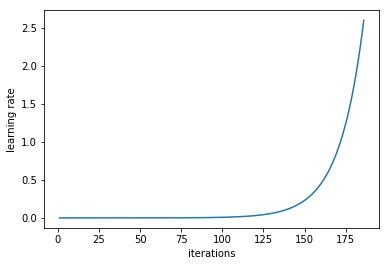

In [14]:
learn.sched.plot_lr()

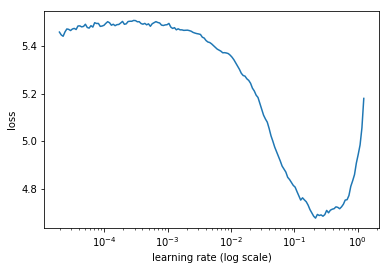

In [20]:
learn.sched.plot(n_skip_end=10)

In [16]:
1e-1

0.1

In [22]:
learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      2.739989   2.788587   0.314904  
    1      2.609392   2.747305   0.327404                   



[2.7473054, 0.32740384655503124]

In [23]:
learn.precompute=False

In [24]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      2.77382    2.74388    0.321154  
    1      2.708856   2.708307   0.341346                   
    2      2.642997   2.706863   0.323077                   



[2.7068634, 0.3230769213002462]

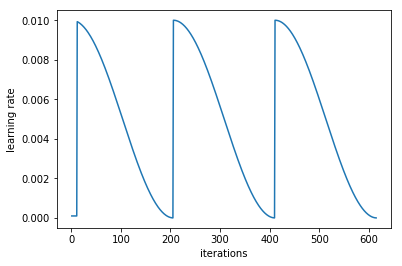

In [99]:
learn.sched.plot_lr()

,id,breed
848,14b27fd74697cf699143ade2d4f801fc,malamute


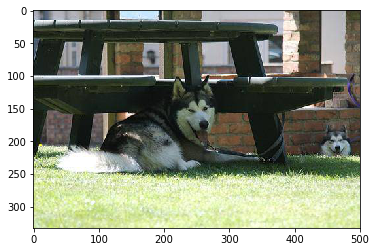

In [54]:
rnd_photo = np.random.choice(learn.data.trn_dl.dataset.fnames)
idx =rnd_photo.replace('.jpg', '').replace('train/','')

img = plt.imread(f'{PATH}{rnd_photo}')
plt.imshow(img); label_df.loc[label_df['id'] == idx]

In [53]:
64*2, 128*2, 299

(128, 256, 299)

In [55]:
learn.set_data(get_data(128, 40, aug=True))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [56]:
learn.fit(1e-2, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.503817   1.159339   0.664904  
    1      1.331322   1.091184   0.680769                   
    2      1.215715   1.041735   0.69375                    



[1.0417348, 0.6937500003438729]

In [58]:
learn.fit(1e-2, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.103818   1.02934    0.696154  
    1      1.093225   1.026394   0.700481                   



[1.0263941, 0.7004807683137747]

In [59]:
learn.unfreeze()

In [60]:
lrs = np.array([1e-4, 1e-3, 1e-2])

In [61]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.36348    1.16549    0.664423  
    1      1.275218   1.123571   0.679327                   
    2      0.960397   1.061016   0.687981                    
    3      1.023652   1.090134   0.677885                    
    4      0.82079    1.065665   0.690385                    
    5      0.743195   1.025002   0.708173                    
    6      0.644984   1.031741   0.703365                    



[1.0317405, 0.7033653866786224]

In [152]:
learn.save('128_full') 

In [171]:
1+2

3

In [16]:
learn.load('128_full')

RuntimeError: While copying the parameter named 0.weight, whose dimensions in the model are torch.Size([1024]) and whose dimensions in the checkpoint are torch.Size([64, 3, 7, 7]).

In [62]:
learn.set_data(get_data(256, 40, aug=True))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [63]:
learn.freeze()

In [64]:
learn.precompute=True

In [65]:
learn.fit(1e-2, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      2.572528   2.670613   0.35625   
    1      2.416806   2.657157   0.348077                   
    2      2.266393   2.647216   0.353365                   



[2.6472158, 0.35336538461538464]

In [67]:
learn.fit(1e-2, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.993099   2.645464   0.359135  
    1      1.972758   2.666826   0.360577                   



[2.666826, 0.36057692422316623]

In [68]:
learn.precompute=False

In [69]:
learn.unfreeze()

In [70]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.721839   0.59032    0.81875   
    1      0.58485    0.531254   0.834135                    
    2      0.473741   0.519424   0.827885                    



[0.51942426, 0.8278846190525935]

In [198]:
learn.set_data(get_data(299, 40, aug=True))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [199]:
learn.freeze()

In [200]:
learn.precompute=True

In [201]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 181/205 [00:03<00:00, 60.33it/s, loss=9.06]


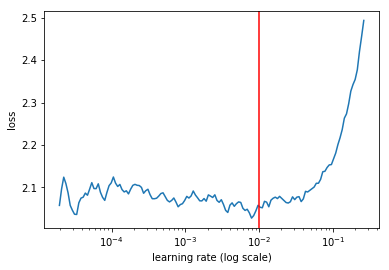

In [214]:
learn.sched.plot(n_skip_end=30); plt.axvline(x=1e-2, color='red');

In [215]:
learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      2.180724   2.727768   0.354808  
    1      2.048517   2.732464   0.357692                   



[2.732464, 0.35769230815080494]

In [218]:
learn.fit(1e-2, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.389588   0.525916   0.844712  
    1      0.360848   0.510664   0.844231                    



[0.5106643, 0.8442307722110015]

In [217]:
learn.unfreeze(); learn.precompute=False;

In [ ]:
lrs300 = np.array([1e-5, 1e-3, 1e-2])
learn.fit(lrs300, 2, cycle_len=1, cylce_mult=2)

In [169]:
learn.save('256_full')

In [182]:
learn.load('256_full')

In [194]:
learn.fit(lrs, 1, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.367159   0.516226   0.839423  



[0.516226, 0.8394230764645797]

### OVERFIT

In [172]:
learn.fit(np.array([1e-5, 1e-4, 1e-3 ]), 2 , cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.334708   0.49612    0.844231  
    1      0.331051   0.487046   0.84375                     
    2      0.327346   0.486072   0.846635                    



[0.486072, 0.8466346149261181]

In [173]:
learn.save('256_tiny_lr'); learn.load('256_tiny_lr')

In [174]:
learn.fit(np.array([1e-5, 1e-3, 1e-2 ]), 2 , cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.338056   0.501902   0.840385  
    1      0.350019   0.528269   0.834615                    
    2      0.273535   0.51515    0.838942                    



[0.51515, 0.838942309984794]

In [184]:
learn.sched.plot_lr??

In [147]:
np.exp(log_preds[4])[:10]

array([[0.01924, 0.00041, 0.     , ..., 0.     , 0.00029, 0.00008],
       [0.00343, 0.00116, 0.00232, ..., 0.03779, 0.00422, 0.00364],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.00001],
       ...,
       [0.     , 0.00043, 0.00017, ..., 0.00002, 0.00001, 0.     ],
       [0.00012, 0.00057, 0.00036, ..., 0.01073, 0.01915, 0.00164],
       [0.00212, 0.00045, 0.0011 , ..., 0.00084, 0.0008 , 0.00696]], dtype=float32)

In [177]:
def create_submission_file(learn):
    log_preds, targs = learn.TTA(is_test=True)
    preds = np.exp(log_preds[0])
    
    breed_col = label_df.sort_values(by=['breed'])

    csv_headers = np.insert(np.unique(np.array(breed_col['breed'])), 0, 'id', axis=0); 
    fnames = list(map(lambda f: f.replace('test/', '').replace('.jpg', ''),data.test_dl.dataset.fnames))
    
    df = pd.DataFrame(data=preds, columns=uniq_breeds)
    df.insert(loc=0, column='id', value=fnames);
    
    df.to_csv(f'{PATH}submission.csv', index=False); 

In [178]:
create_submission_file(learn)